In [1]:
import os
import sys
import cv2
import glob
import random
import shutil
import pandas as pd
import matplotlib.pyplot as plt

# fastai stuff
import fastbook
fastbook.setup_book()
import timm
from fastai.vision.all import *
from fastbook import *
from fastai.vision.widgets import *

In [2]:
# center the matplotlib plots to the middle of the notebook
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### See which categories we have in the dataset and how many images in each category

In [7]:
data_path = "./data/"
categories = [cat for cat in os.listdir(data_path) if cat[0] in ['F', 'R']]
categories

['FreshBanana',
 'RottenPomegranate',
 'FreshJujube',
 'FreshOrange',
 'RottenOrange',
 'RottenJujube',
 'FreshGuava',
 'RottenGrape',
 'FreshApple',
 'RottenBanana',
 'RottenGuava',
 'FreshStrawberry',
 'RottenStrawberry',
 'RottenApple',
 'FreshGrape',
 'FreshPomegranate']

In [8]:
category_sizes = {c:len(glob.glob(os.path.join(data_path, c, "*.jpg"))) for c in categories}
category_sizes = dict(sorted(category_sizes.items(), key=lambda x: x[0]))  # sort the dictionary by keys
category_names = sorted(list({name.replace("Fresh", "").replace("Rotten", "") for name in category_sizes.keys()}))

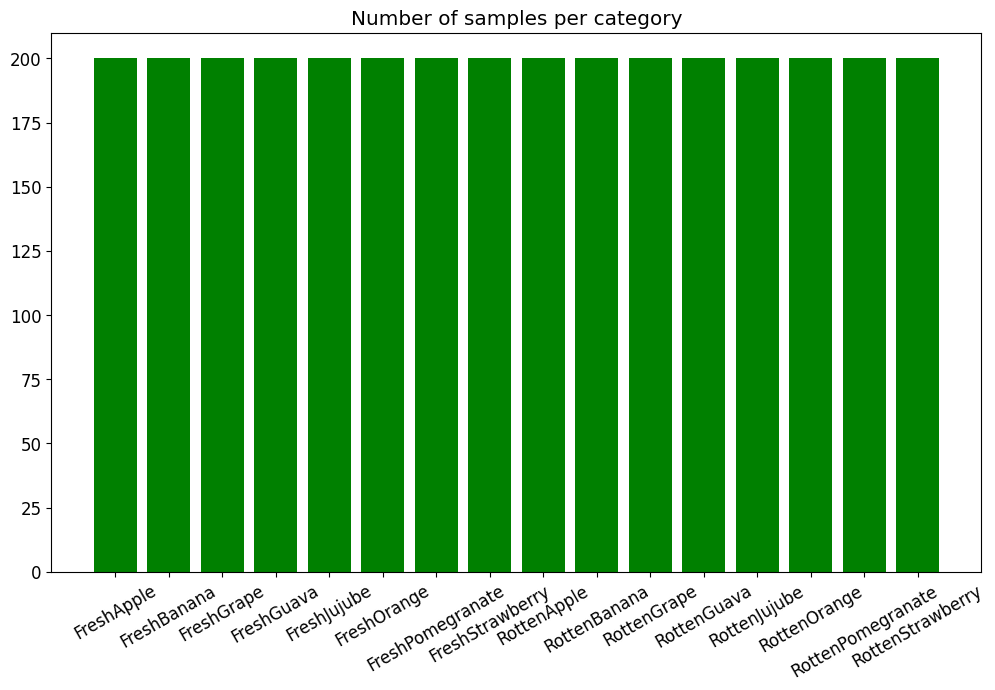

In [9]:
plt.figure(figsize=(12, 7))
plt.bar(category_sizes.keys(), category_sizes.values(), color='g')
plt.xticks(rotation=30)
plt.title("Number of samples per category")
plt.show()

### Visualize a few images from each category

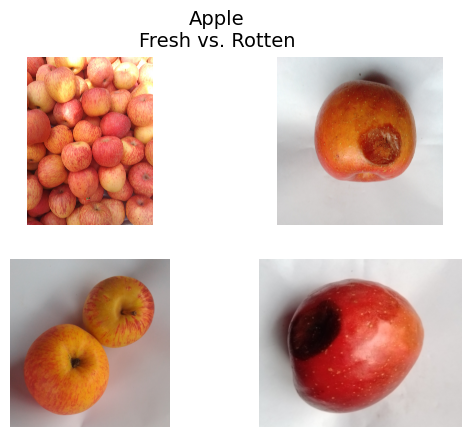

---------------------------------------------------------------------------------------------------------------------


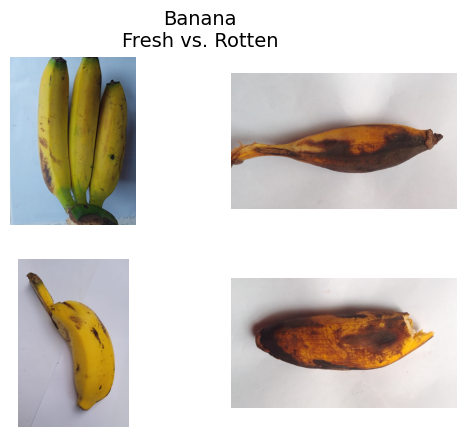

---------------------------------------------------------------------------------------------------------------------


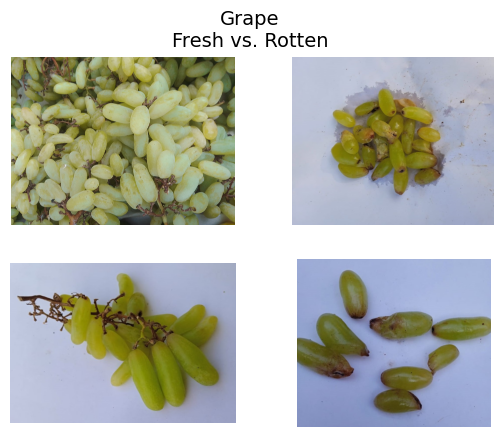

---------------------------------------------------------------------------------------------------------------------


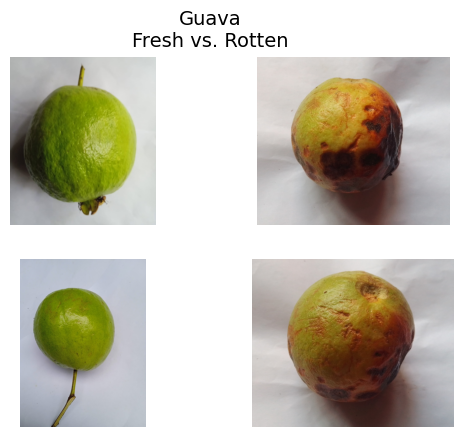

---------------------------------------------------------------------------------------------------------------------


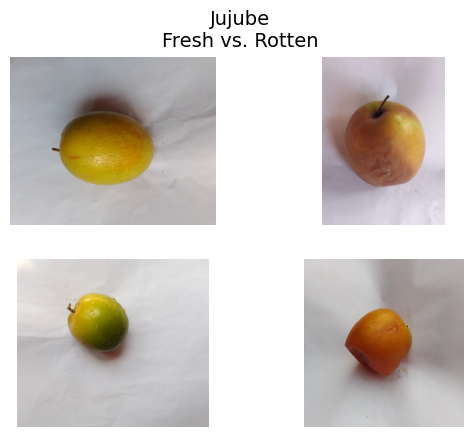

---------------------------------------------------------------------------------------------------------------------


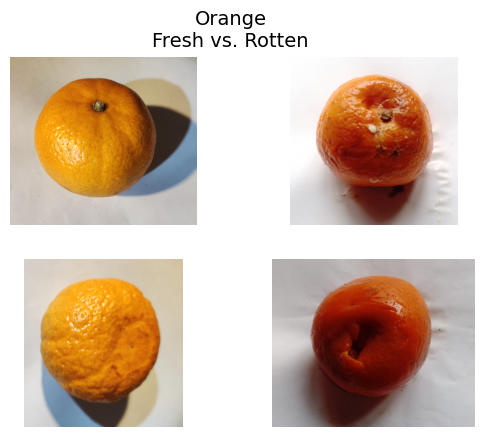

---------------------------------------------------------------------------------------------------------------------


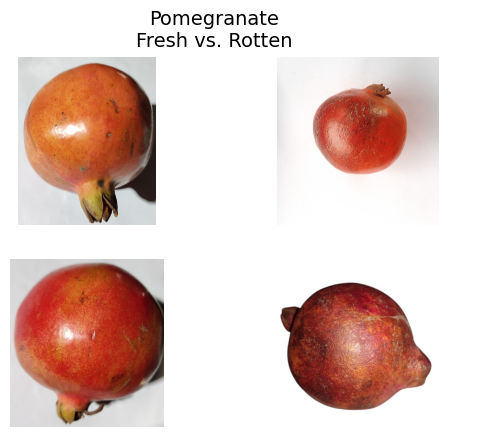

---------------------------------------------------------------------------------------------------------------------


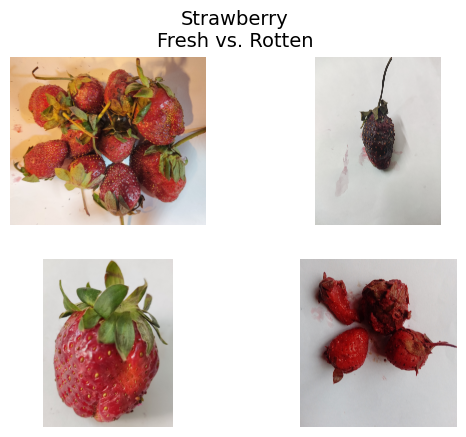

---------------------------------------------------------------------------------------------------------------------


In [10]:
# For each fruit:
#    - create 4 subplots
#    - on the 2 plots on the left: plot fresh examples of the fruit
#    - on the 2 plots on the right: plot rotten examples of the fruit

for category_name in category_names:
    fresh_version_name = "Fresh" + category_name
    rotten_version_name = "Rotten" + category_name
    
    fresh_fruits_paths = glob.glob(os.path.join(data_path, fresh_version_name, "*.jpg"))
    rotten_fruits_paths = glob.glob(os.path.join(data_path, rotten_version_name, "*.jpg"))
    
    fresh_fruits_sample = random.sample(fresh_fruits_paths, k=2)
    rotten_fruits_sample = random.sample(rotten_fruits_paths, k=2)
    
    fresh_fruits = [cv2.cvtColor(cv2.imread(t), cv2.COLOR_BGR2RGB) for t in fresh_fruits_sample]
    rotten_fruits = [cv2.cvtColor(cv2.imread(t), cv2.COLOR_BGR2RGB) for t in rotten_fruits_sample]
    
    fig = plt.gcf()
    fig.suptitle(f"{category_name}\nFresh vs. Rotten", fontsize=14)
    
    plt.subplot(2, 2, 1)
    plt.imshow(fresh_fruits[0])
    plt.axis("off")
    
    plt.subplot(2, 2, 3)
    plt.imshow(fresh_fruits[1])
    plt.axis("off")
    
    plt.subplot(2, 2, 2)
    plt.imshow(rotten_fruits[0])
    plt.axis("off")
    
    plt.subplot(2, 2, 4)
    plt.imshow(rotten_fruits[1])
    plt.axis("off")
    
    plt.show()
    print('-' * 117)

### Create a train/valid/test split

`- 200 images for each category`

`- use a 70/15/15 split`

`=> 140/30/30 images for train/valid/test for each category`

We will use the images in the following file format (ImageNet-like):

/data 

     /train
           /FreshApple
           /FreshBanana
           ...
           /FreshStrawberry
           /RottenApple
           ...
           /RottenStrawberry
     /valid
           /FreshApple
           /FreshBanana
           ...
           /FreshStrawberry
           /RottenApple
           ...
           /RottenStrawberry
     /test     
          /FreshApple
          /FreshBanana
          ...
          /FreshStrawberry
          /RottenApple
          ...
          /RottenStrawberry

In [11]:
# create the file structure
for category_name in category_names:
    fresh_version_name = "Fresh" + category_name
    rotten_version_name = "Rotten" + category_name
    
    os.makedirs(os.path.join("./data", "train", fresh_version_name), exist_ok=True)
    os.makedirs(os.path.join("./data", "train", rotten_version_name), exist_ok=True)
    
    os.makedirs(os.path.join("./data", "valid", fresh_version_name), exist_ok=True)
    os.makedirs(os.path.join("./data", "valid", rotten_version_name), exist_ok=True)
    
    os.makedirs(os.path.join("./data", "test", fresh_version_name), exist_ok=True)
    os.makedirs(os.path.join("./data", "test", rotten_version_name), exist_ok=True)

In [12]:
TRAIN_SIZE = 140
VALID_SIZE = 30
TEST_SIZE = 30

for category_name in category_names:
    fresh_version_name = "Fresh" + category_name
    rotten_version_name = "Rotten" + category_name
    
    fresh_fruits_paths = glob.glob(os.path.join(data_path, fresh_version_name, "*.jpg"))
    rotten_fruits_paths = glob.glob(os.path.join(data_path, rotten_version_name, "*.jpg"))
    
    # shuffle the images
    fresh_fruits_paths = random.sample(fresh_fruits_paths, k=len(fresh_fruits_paths))
    rotten_fruits_paths = random.sample(rotten_fruits_paths, k=len(rotten_fruits_paths))
    
    # save the train files
    # fresh
    train_fresh_files = fresh_fruits_paths[:TRAIN_SIZE]
    for t in train_fresh_files:
        shutil.copy2(t, os.path.join(f"./data/train/{fresh_version_name}", os.path.basename(t)))
    # rotten
    train_rotten_files = rotten_fruits_paths[:TRAIN_SIZE]
    for t in train_rotten_files:
        shutil.copy2(t, os.path.join(f"./data/train/{rotten_version_name}", os.path.basename(t)))
        
    # do the same for valid and test
    valid_fresh_files = fresh_fruits_paths[TRAIN_SIZE : TRAIN_SIZE+VALID_SIZE]
    for t in valid_fresh_files:
        shutil.copy2(t, os.path.join(f"./data/valid/{fresh_version_name}", os.path.basename(t)))
    # rotten
    valid_rotten_files = rotten_fruits_paths[TRAIN_SIZE : TRAIN_SIZE+VALID_SIZE]
    for t in valid_rotten_files:
        shutil.copy2(t, os.path.join(f"./data/valid/{rotten_version_name}", os.path.basename(t)))  
        
    test_fresh_files = fresh_fruits_paths[TRAIN_SIZE+VALID_SIZE:]
    for t in test_fresh_files:
        shutil.copy2(t, os.path.join(f"./data/test/{fresh_version_name}", os.path.basename(t)))
    # rotten
    test_rotten_files = rotten_fruits_paths[TRAIN_SIZE+VALID_SIZE:]
    for t in test_rotten_files:
        shutil.copy2(t, os.path.join(f"./data/test/{rotten_version_name}", os.path.basename(t)))

### Load the data into dataloaders and apply various augmentations

In [17]:
dls = ImageDataLoaders.from_folder("./data/", 
                                   item_tfms=Resize(500),
                                   batch_tfms=[*aug_transforms(size=224, 
                                                               flip_vert=True, 
                                                               max_rotate=30.0, 
                                                               max_lighting=0.6,
                                                               max_warp=0.4, 
                                                               max_zoom=1.3, 
                                                               min_scale=0.75), 
                                               Normalize.from_stats(*imagenet_stats)], 
                                   bs=32)

### See how the augmented data looks

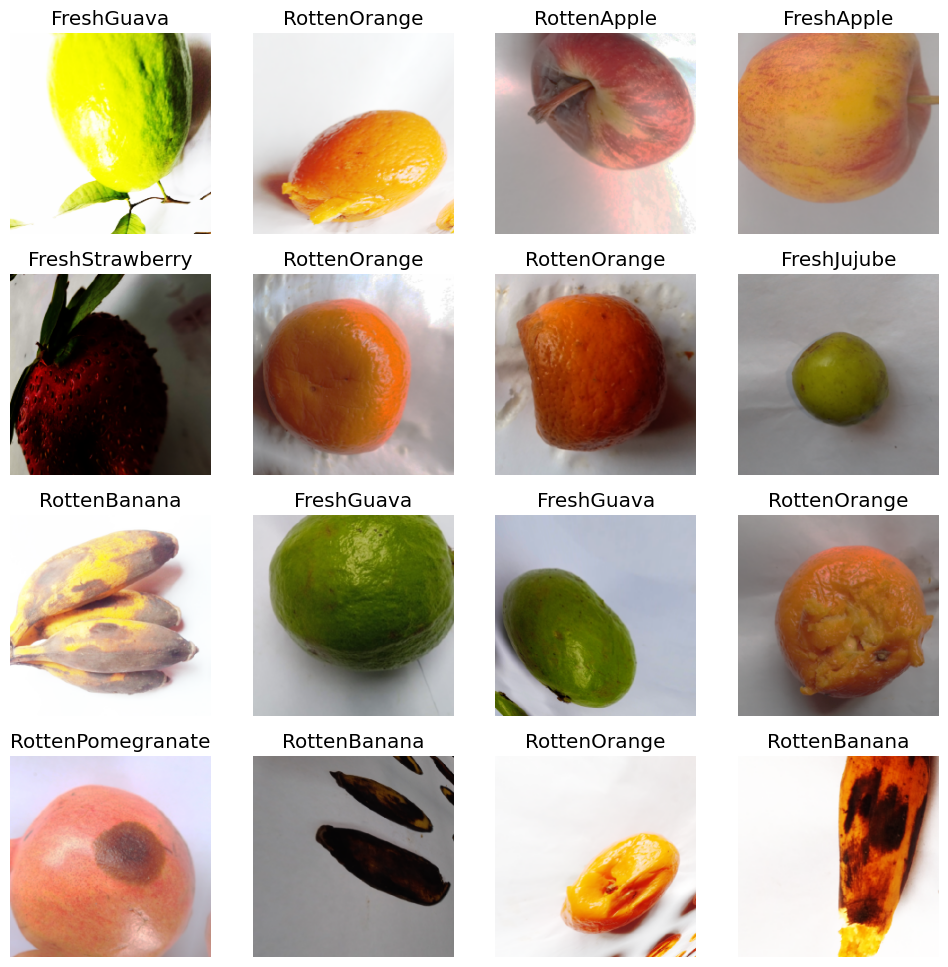

In [18]:
dls.show_batch(max_n=16)

### See how one image is transformed when apply various augmentations
#### So below we have multiple variations of the same unique image. The variations are created by applying augmentations

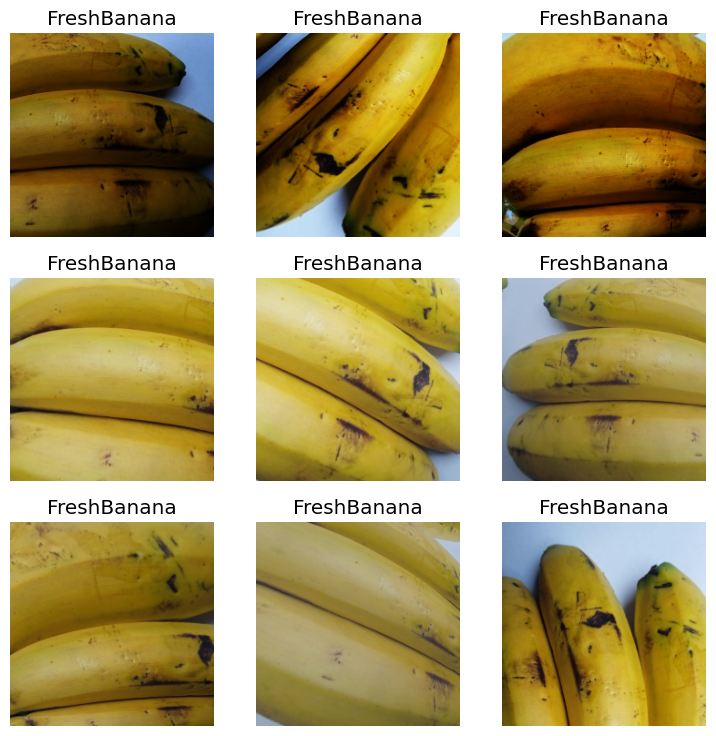

In [19]:
dls.show_batch(unique=True)